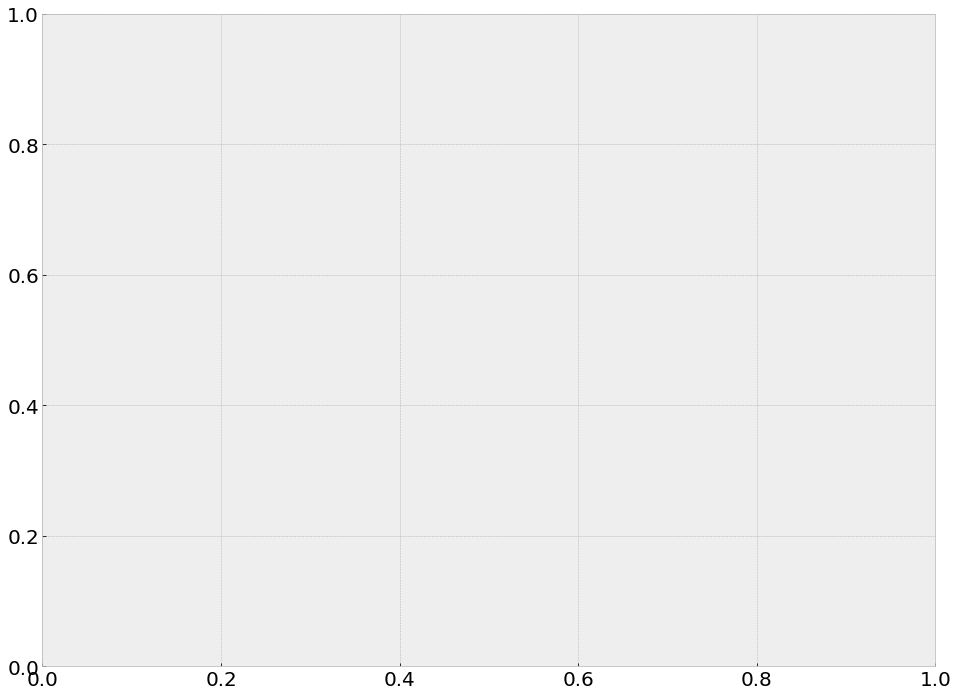

In [1]:
from cwgan_base import *
import math
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from scipy.stats import multivariate_normal, beta
import matplotlib._pylab_helpers

plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

from itertools import product
from tqdm import tqdm

In [2]:
# Decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
#true g
def g(x):
    g=np.zeros((x.shape[0], 10))
    g[:,0] = np.sin(x[:,0])
    g[:,1] = np.sin(x[:,1])
    g[:,2] = np.sin(x[:,2])
    g[:,3] = np.exp(x[:,0])
    g[:,4] = 2*np.sqrt(x[:,1])
    g[:,5] = np.cos(2*math.pi*x[:,0]*x[:,1]*x[:,2])
    g[:,6] = x[:,0]*x[:,1]*x[:,2]
    g[:,7] = np.sqrt(np.sum(x, axis=1))
    g[:,8] = np.sum(x,axis=1)
    g[:,9] = np.linalg.norm(x, axis = 1)
    return(g)

In [4]:
def generate_data(num=1000):
    z = torch.rand((num, 3), device = device)
    return(g(z.cpu().detach().numpy()))
    

def get_coverage(trainer, num = 1000, runs = 5):
    covs= []
    for i in range(runs):
        # only X1+X2+...+X10
        gens = np.sum(trainer.generate_images(num_outputs = num).detach().cpu().numpy(), 1)
        reals = np.sum(generate_data(num=num), 1)
        
        gens = np.sort(gens)
        lower = gens[int(np.ceil(0.5*alpha*num))]
        upper = gens[int(np.ceil((1-0.5*alpha)*num))]
        covs.append( sum([lower<=reals[i]<= upper for i in range(num)])/num )
        
    #return mean coverage, std coverage
    return(np.mean(covs), np.std(covs))
    
def compute_ot(trainer, num = 1000, runs = 5):
    ots = []
    for i in range(runs):
        gens = trainer.generate_images(num_outputs=num).detach().numpy()
        reals = generate_data(num=num)
        ots.append(get_ot(gens,reals))
    return(np.mean(ots), np.std(ots))

In [5]:
z_dim=10
x_dim = 10
ddim= 128
gdim = 32
n_batches = 100
# number of ot and cov estims
num_otruns = 1
# number of equal models trained
model_runs = 5 #5

alpha = 0.05

bs = 64

#train to test ratio
tt = 0.5
#n batches
N = [1, 5, 15, 50, 150] #[3, 15, 150, 750]

# continue training for EP epochs 
EP = [100, 200, 400] # [100,200,400,400]
models=[]
trainers=[]
COV=-1000 * np.ones((len(N),len(EP), 2))
OT=-1000 * np.ones((len(N),len(EP), 2))



# gen and discr architectures for each n in N
PG = []
PD = []

gdim = 32
ddim = 128
for _ in range(len(N)):
    PG.append( (z_dim,gdim,gdim,gdim, x_dim) )
    PD.append( (x_dim, ddim, ddim, ddim, ddim, ddim, 1) )

  0%|          | 0/100 [00:00<?, ?it/s]

N= 1


  0%|          | 0/100 [00:00<?, ?it/s]

N= 5


  0%|          | 0/100 [00:00<?, ?it/s]

N= 15


  0%|          | 0/100 [00:00<?, ?it/s]

N= 50


  0%|          | 0/100 [00:00<?, ?it/s]

N= 150


100%|██████████| 400/400 [14:08<00:00,  2.12s/it]


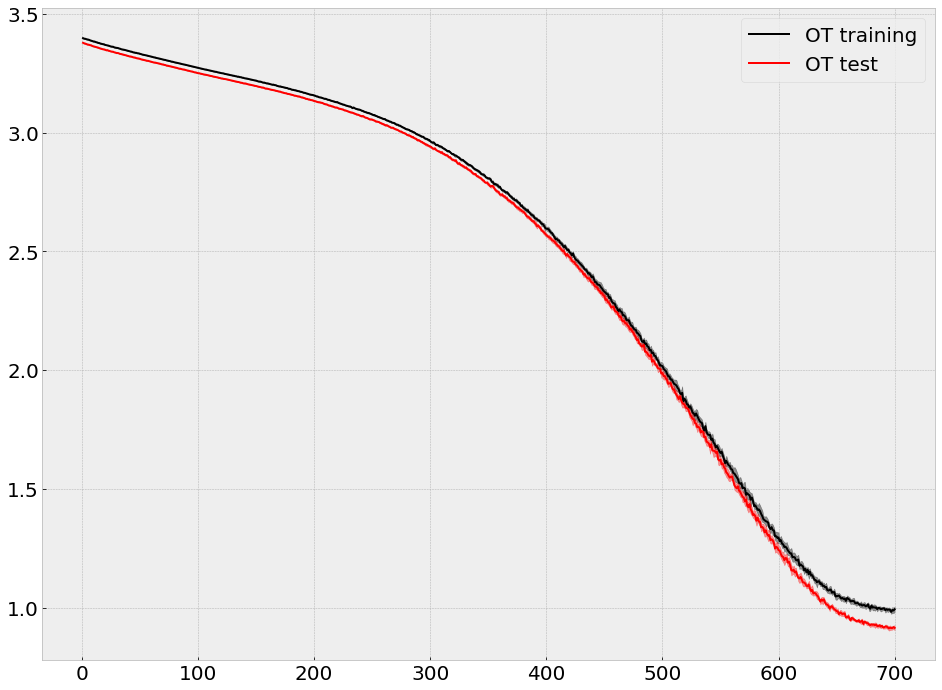

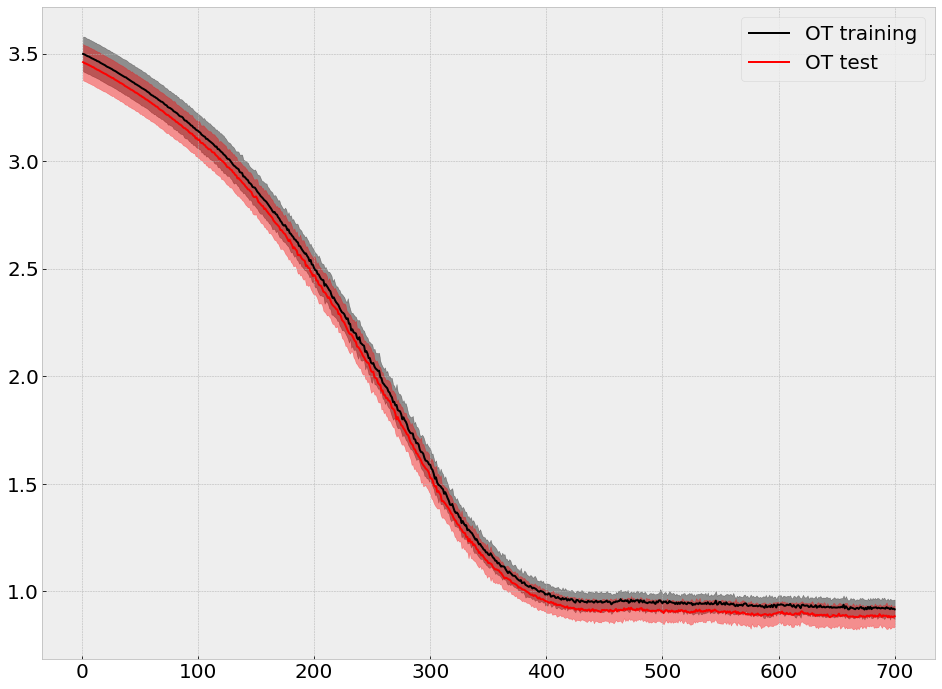

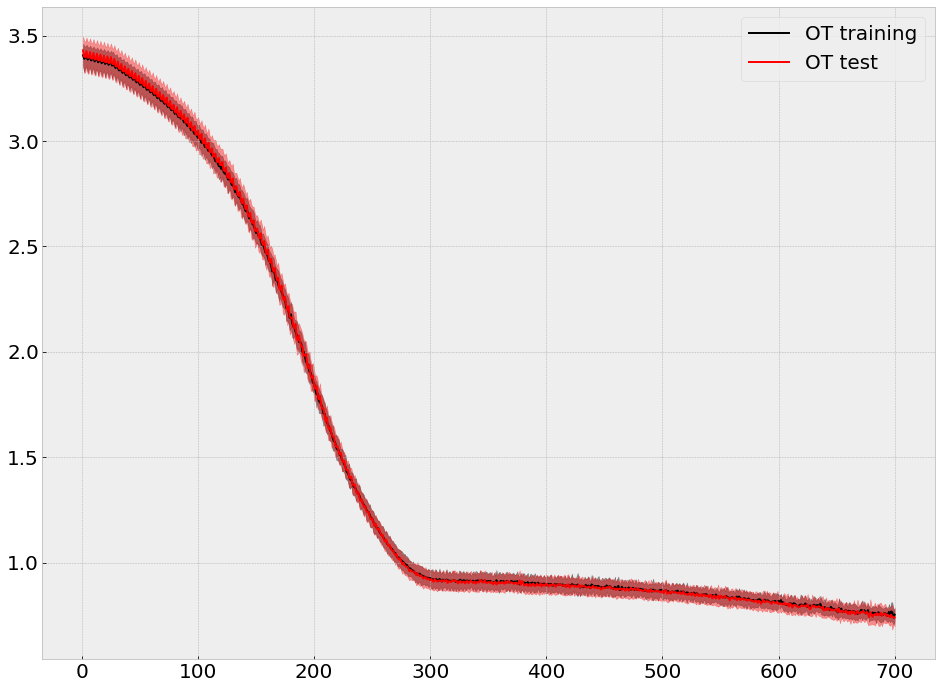

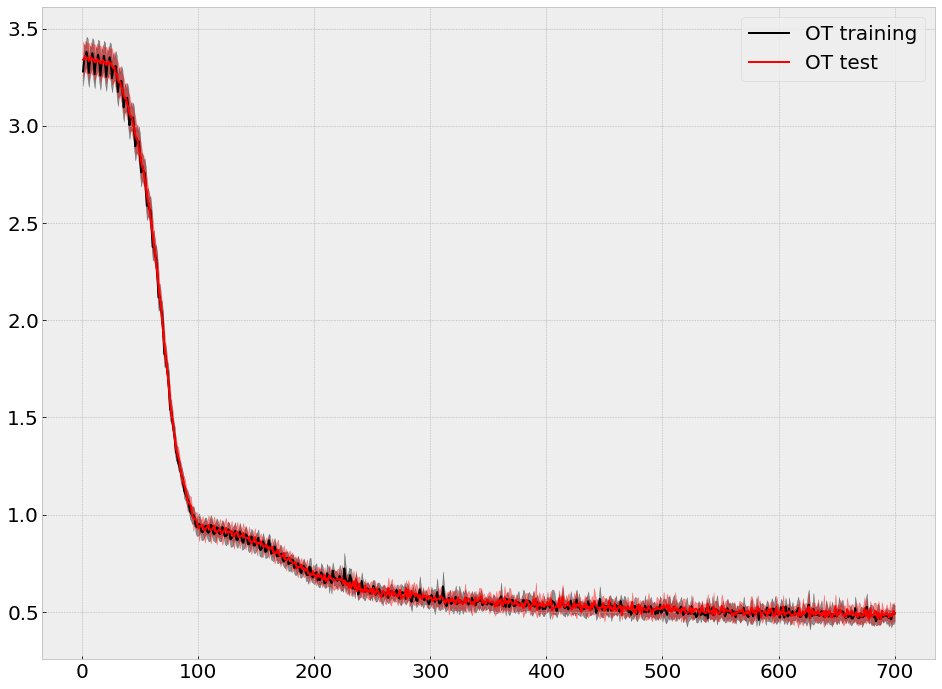

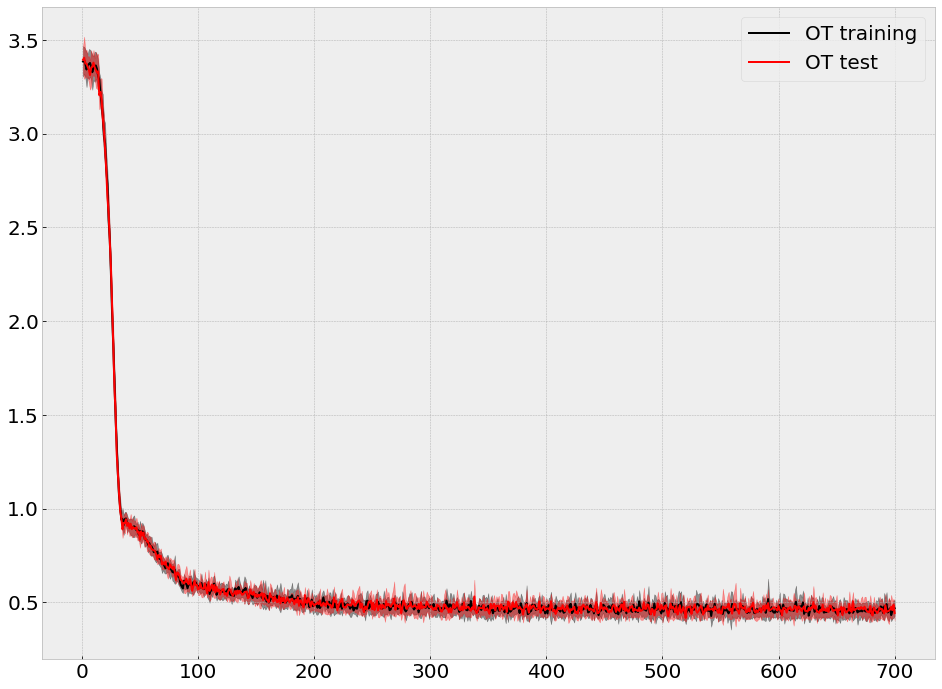

In [6]:
random.seed(1057)
torch.manual_seed(1057)

for i in range(len(N)):
    print('N=',N[i])
    n_batches = N[i]
    
    pg = PG[i]
    pd = PD[i]

    cs = -1000 * np.ones((len(EP),model_runs))
    os = -1000 * np.ones((len(EP),model_runs))
    
    for r in range(model_runs):
        data = generate_data(num=bs*n_batches*2)
        y = np.zeros(data.shape[0])
        trains, tests = get_cdataloader(data, y, tt_split = tt, shuffle = False)
        models.append( WGAN(pg, pd) )
        trainers.append( WGANTrainer(model=models[-1], trains=trains, testset = tests, viz=False, gantype = 'wgangp', noise = 'unif') )

        # train D and G with estimates after each epoch, use num_batches for estimates
        #train for 100, 200, 400, 400
        for i_ep in range(len(EP)):
            trainers[-1].train_estim(num_epochs=EP[i_ep], penalty = 0.1, G_lr=1e-4, D_lr=1e-4, G_wd = 0.01, D_steps_standard=5, num_batches = 1, num_estims = 10, onlypot = True)
            cs[i_ep,r] = get_coverage(trainers[-1], num = 1000, runs = num_otruns)[0] #[0] for num_otruns = 1
            os[i_ep,r] = compute_ot(trainers[-1], num = 1000, runs = num_otruns)[0]
        
        
    for i_ep in range(len(EP)):
        COV[i, i_ep, :] = np.mean(cs[i_ep,:]), np.std(cs[i_ep,:])
        OT[i, i_ep, :] = np.mean(os[i_ep,:]), np.std(os[i_ep,:])
    
    
    ys = np.array(trainers[-1].W1s)
    upper = len(ys) #500
    xs = np.linspace(1,upper,upper)
    y2 = np.array(trainers[-1].W1test)

    plt.figure(i)
    plt.rcParams["figure.figsize"] = (8*2,6*2)
    plt.style.use('bmh')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize = 20)
    plt.plot(xs, ys[:,0], '-', color='black', label = 'OT training')
    plt.fill_between(xs, ys[:,0] - ys[:,1], ys[:,0] + ys[:,1],
                     color='black', alpha=0.4)
    plt.plot(xs, y2[:,0], '-', color='red', label = 'OT test')
    plt.fill_between(xs, y2[:,0] - y2[:,1], y2[:,0] + y2[:,1],
                     color='red', alpha=0.4)
    plt.legend(fontsize = 20)
    #plt.ylim(-0.5,1.5)
    plt.savefig('to10_%d.png'%i,dpi=150)    

In [7]:
COV

array([[[0.        , 0.        ],
        [0.0028    , 0.00365513],
        [0.8208    , 0.0484867 ]],

       [[0.        , 0.        ],
        [0.0396    , 0.07521861],
        [0.8338    , 0.02755649]],

       [[0.        , 0.        ],
        [0.8728    , 0.03057712],
        [0.9618    , 0.01698705]],

       [[0.8054    , 0.05490209],
        [0.9272    , 0.01715109],
        [0.9466    , 0.00508331]],

       [[0.9328    , 0.01913531],
        [0.937     , 0.00648074],
        [0.9398    , 0.013891  ]]])

In [8]:
OT

array([[[3.19644979, 0.0896253 ],
        [2.59967532, 0.19413613],
        [0.94744662, 0.05920462]],

       [[3.132415  , 0.05182596],
        [2.28364189, 0.39512649],
        [0.91081429, 0.02238582]],

       [[2.91071068, 0.1579593 ],
        [0.89836891, 0.01139106],
        [0.61985497, 0.07029149]],

       [[0.91287614, 0.02518448],
        [0.43882164, 0.01479542],
        [0.26098456, 0.00869404]],

       [[0.48967655, 0.04229867],
        [0.24291409, 0.01464327],
        [0.19772706, 0.00887195]]])

In [9]:
for i in range(len(trainers)):
    torch.save(models[i] , 'model_%d.pt'%i)

In [10]:
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)

ys = np.array(trainer[0].W1s)
upper = len(ys) #500
xs = np.linspace(1,upper,upper)
y2 = np.array(trainer[0].W1test)


plt.figure()
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
plt.plot(xs, ys[:,0], '-', color='black', label = 'OT training')
plt.fill_between(xs, ys[:,0] - ys[:,1], ys[:,0] + ys[:,1],
                 color='black', alpha=0.4)
plt.plot(xs, y2[:,0], '-', color='red', label = 'OT test')
plt.fill_between(xs, y2[:,0] - y2[:,1], y2[:,0] + y2[:,1],
                 color='red', alpha=0.4)
plt.legend(fontsize = 20)
#plt.ylim(-0.5,1.5)
plt.savefig('to10',dpi=150)

In [11]:
#pl.figure(0)

test_idx = int(np.ceil(0.8*bs*n_batches))

train_gens = trainer.generate_images(num_outputs=test_idx).detach().numpy()
trains = data[:test_idx,:]
test_gens = trainer.generate_images(num_outputs=bs*n_batches-test_idx).detach().numpy()
tests = data[test_idx:,:]

W1_train = get_ot(trains, train_gens)
W1_test = get_ot(tests, test_gens)
W1_train,W1_test

figures=[manager.canvas.figure for manager in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
print(figures)

# [<matplotlib.figure.Figure object at 0xb788ac6c>, <matplotlib.figure.Figure object at 0xa143d0c>]

for i, figure in enumerate(figures):
    figure.savefig('figure%d.png' % i)

test_idx = int(np.ceil(0.8*bs*n_batches))

train_gens = trainer.generate_images(num_outputs=test_idx).detach().numpy()
trains = data[:test_idx,:]
test_gens = trainer.generate_images(num_outputs=bs*n_batches-test_idx).detach().numpy()
tests = data[test_idx:,:]

W1_train = get_ot(trains, train_gens)
W1_test = get_ot(tests, test_gens)
W1_train,W1_test